In [96]:
%pylab inline
import urllib, json
import pandas as pd
import re
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing


Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [97]:
# concatenate the data from 2017, 2018 and 2019 into one Dataframe
files = ['NFL2017.csv', 'NFL2018.csv', 'NFL2019.csv']

f = []

for file in files:
    df = pd.read_csv(file).fillna(0)
    f.append(df)
    
data = pd.concat(f, axis=0, ignore_index=True)

In [98]:
# Drop the more advanced statistics/roles that we will not be using in this analysis.
# This reduces the number of features from 117 to 30 which will significantly improve the speed of the models.
data_2 = data.drop(['Date', 'Week', 'Year', 'Game ID', 'Opponent Score', 'OT', 'Spread', 'Over/Under', 'Implied Points', 
                    'Actual Margin', 'Rush Lng', 'Weather', 'Pass Lng', 'DKP',
                    'Rec Lng', 'FL', 'Kick Ret', 'Kick Yds', 'Kick TD', 'Kick Lng', 'Kick YPR', 'Punt Ret', 'Punt Yds',
                    'Punt TD', 'Punt Lng', 'Punt YPR', 'Short L Tgt', 'Short L Ctch', 'Short L Yds', 'Short L TD', 
                    'Short M Tgt', 'Short M Ctch', 'Short M Yds', 'Short M TD', 'Short R Tgt', 'Short R Ctch', 
                    'Short R Yds', 'Short R TD', 'Deep L Tgt', 'Deep L Yds', 'Deep L TD', 'Deep L Ctch', 'Deep M Tgt', 'Deep M Ctch',
                    'Deep M Yds', 'Deep M TD', 'Deep R Tgt', 'Deep R Ctch', 'Deep R Yds', 'Deep R TD', 'No Dir Tgt', 
                    'No Dir Ctch', 'No Dir Yds', 'No Dir TD', 'Off Num', '2PT', 'Def Num', 'Def Pct', 'ST Num', 'ST Pct', 'Pnt', 'Yds',
                    'Y/P', 'Sk', 'Int', 'Int TD', 'FF', 'FR', 'Fum TD', 'QBHits', 'TFL', 'Oppt Int TD', 'Oppt Fum TD',
                    'Oppt Punt TD', 'Oppt Kick TD', 'FGM', 'FGA', 'FG 0-19', 'FG 20-29', 'FG 30-39', 'FG 40-49', 
                    'FG 50+', 'XPM', 'XPA', 'FDP', 'FDSalary', 'FD_Total_FP', 'YH_Total_FP'], axis=1)

In [99]:
# Also delete the Defensive, Fullback and Kicker player positions, as these are not chosen by the user in Draft Kings.
data_filtered = data_2[(data_2.Pos != 'K') & (data_2.Pos != 'DST') & (data_2.Pos != 'FB')] 

In [100]:
final_data = data_filtered

In [101]:
final_data

,Player,Pos,Team,Opponent Abbrev,H/A,Team Score,Indoor/Outdoor,Surface,Temperature,Wind,...,Rush Yds,Rush TD,Rec Tgt,Rec Rec,Rec Yds,Rec TD,Fmb,Off Pct,DKSalary,DK_Total_FP
0,Alex Smith,QB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,100%,5400.0,34.02
1,Kareem Hunt,RB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,148.0,1.0,5.0,5.0,98.0,2.0,1.0,57%,5800.0,49.60
2,Charcandrick West,RB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,21.0,1.0,1.0,1.0,4.0,0.0,0.0,34%,4000.0,9.50
3,Tyreek Hill,WR,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,5.0,0.0,8.0,7.0,133.0,1.0,1.0,74%,5700.0,29.80
4,Travis Kelce,TE,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,4.0,0.0,7.0,5.0,40.0,0.0,0.0,99%,5600.0,9.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,Hunter Henry,TE,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,0.0,9.0,6.0,69.0,0.0,0.0,76%,5700.0,14.90
15509,Virgil Green,TE,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,0.0,1.0,1.0,8.0,0.0,0.0,30%,2500.0,1.80
15510,Troymaine Pope,RB,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1%,3000.0,0.00
15511,Andre Patton,WR,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,74%,3000.0,0.00


In [102]:
raw_data = final_data

In [103]:
# need to use OneHotEncoder and ColumnTransformer to turn the categorical data into numbers for the model to use
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

# our features data
features = final_data.drop('DK_Total_FP', axis=1)
feature_list = list(features.columns)

# need to convert all the non-numeric features into categorical data
features['Player'] = features['Player'].astype('category').cat.codes
features['Pos'] = features['Pos'].astype('category').cat.codes
features['Team'] = features['Team'].astype('category').cat.codes
features['Opponent Abbrev'] = features['Opponent Abbrev'].astype('category').cat.codes
features['H/A'] = features['H/A'].astype('category').cat.codes
features['Indoor/Outdoor'] = features['Indoor/Outdoor'].astype('category').cat.codes
features['Surface'] = features['Surface'].astype('category').cat.codes
features['Off Pct'] = features['Off Pct'].str.rstrip('%').astype('float') / 100

In [104]:
# now each of the non-numeric features have been assigned a category
features

,Player,Pos,Team,Opponent Abbrev,H/A,Team Score,Indoor/Outdoor,Surface,Temperature,Wind,...,Rush Att,Rush Yds,Rush TD,Rec Tgt,Rec Rec,Rec Yds,Rec TD,Fmb,Off Pct,DKSalary
0,17,0,15,21,0,42.0,2,3,63.0,8.0,...,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,5400.0
1,469,1,15,21,0,42.0,2,3,63.0,8.0,...,17.0,148.0,1.0,5.0,5.0,98.0,2.0,1.0,0.57,5800.0
2,131,1,15,21,0,42.0,2,3,63.0,8.0,...,1.0,21.0,1.0,1.0,1.0,4.0,0.0,0.0,0.34,4000.0
3,790,3,15,21,0,42.0,2,3,63.0,8.0,...,2.0,5.0,0.0,8.0,7.0,133.0,1.0,1.0,0.74,5700.0
4,764,2,15,21,0,42.0,2,3,63.0,8.0,...,1.0,4.0,0.0,7.0,5.0,40.0,0.0,0.0,0.99,5600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,330,2,16,15,1,17.0,2,4,67.0,7.0,...,0.0,0.0,0.0,9.0,6.0,69.0,0.0,0.0,0.76,5700.0
15509,798,2,16,15,1,17.0,2,4,67.0,7.0,...,0.0,0.0,0.0,1.0,1.0,8.0,0.0,0.0,0.30,2500.0
15510,779,1,16,15,1,17.0,2,4,67.0,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.01,3000.0
15511,31,3,16,15,1,17.0,2,4,67.0,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.74,3000.0


In [105]:
scaler = preprocessing.StandardScaler()
feats = scaler.fit_transform(features)

In [106]:
# our standardized data 
feats

array([[-1.63477747, -1.80074988, -0.05630625, ..., -0.29896445,
         1.42225732,  0.74042905],
       [ 0.26422836, -0.86701739, -0.05630625, ...,  2.39937098,
         0.03597946,  0.98459094],
       [-1.15582467, -0.86701739, -0.05630625, ..., -0.29896445,
        -0.705518  , -0.11413757],
       ...,
       [ 1.56664386, -0.86701739,  0.05143174, ..., -0.29896445,
        -1.76940567, -0.7245423 ],
       [-1.5759587 ,  1.00044758,  0.05143174, ..., -0.29896445,
         0.5840428 , -0.7245423 ],
       [-0.11809361,  1.00044758,  0.05143174, ..., -0.29896445,
        -1.1891033 , -0.7245423 ]])

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# first, our labels in numpy array (the actual scored points for each instance of the data)
labels = np.array(final_data['DK_Total_FP'])

# split into testing and training data
train_features, test_features, train_labels, test_labels = train_test_split(feats, labels, test_size=0.3, 
                                                                            random_state=3)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

rf = RandomForestRegressor(n_estimators=30, random_state=3, bootstrap=True)

rf.fit(train_features, train_labels)

Training Features Shape: (9375, 28)
Training Labels Shape: (9375,)
Testing Features Shape: (4019, 28)
Testing Labels Shape: (4019,)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=3, verbose=0,
                      warm_start=False)

In [108]:
# now we have our model
predictions = rf.predict(test_features)

In [109]:
# look at results
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, predictions)))
print('R2 Score:', metrics.r2_score(test_labels, predictions))

Mean Absolute Error: 0.5144278012772665
Mean Squared Error: 1.634714060656327
Root Mean Squared Error: 1.2785593692341106
R2 Score: 0.9784516824212058


In [110]:
# feature importances - the sum of reduction of Gini Impurity over all nodes split on each feature. 
importances = list(rf.feature_importances_)
feature_importances = pd.DataFrame(rf.feature_importances_, index = feature_list,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
Rec Yds,0.297878
DKSalary,0.220970
Pass TD,0.107105
Rush TD,0.098156
Rec TD,0.083191
Rush Yds,0.077971
Rec Rec,0.052591
Pass Yds,0.038024
Pass Rate,0.004614
Rush Att,0.004044


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


(33, 0)

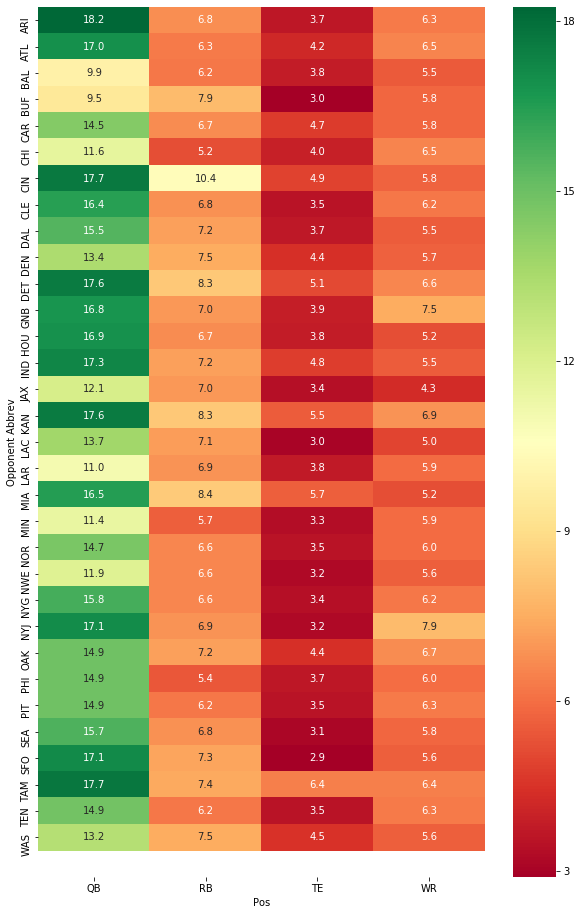

In [111]:
plt.figure(figsize=(10,16))
locations = []

for i in final_data['Indoor/Outdoor']:
    if i == 'outdoors':
        locations.append('Outdoors')
    else:
        locations.append('Indoors')
        
# features we want to look at by position are H/A, indoors/outdoors/, opponent?
reduced_features = final_data[['Pos', 'DK_Total_FP']]
reduced_features['Location'] = locations


df = final_data.pivot_table(index='Opponent Abbrev', columns='Pos', values='DK_Total_FP', aggfunc=np.median)
ax = sns.heatmap(df, cmap="RdYlGn", annot=True, fmt=".1f")
# plt.show
ax.get_ylim()
ax.set_ylim(33, 0)

In [112]:
# now run the model using a neural network 
from sklearn.neural_network import MLPRegressor

# use all the default sklearn parameters (relu activation, adam solver, etc.)
nn = MLPRegressor()

nn.fit(train_features, train_labels)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [113]:
nn_predictions = nn.predict(test_features)

In [114]:
print('Neural Network - MLP Regressor')
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, nn_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, nn_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, nn_predictions)))
print('R2 Score:', metrics.r2_score(test_labels, nn_predictions))

Neural Network - MLP Regressor
Mean Absolute Error: 0.3574139163814177
Mean Squared Error: 0.3926324718832936
Root Mean Squared Error: 0.6266039194605262
R2 Score: 0.9948244348051357


In [115]:
# now let's try with a few Regression models
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

kfold = KFold(n_splits=5, random_state=3)

# for Ridge Regression, use GridSearchCV in order to test for the optinal value of alpha.
rr = Ridge()
ridge_params = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
ridge_reg = GridSearchCV(rr, ridge_params, cv=5)
ridge_reg.fit(train_features, train_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [116]:
rr_predictions = ridge_reg.predict(test_features)

print('Ridge Regression')
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, rr_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, rr_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, rr_predictions)))
print('Best Parameter:', ridge_reg.best_params_)
print('Best MSE:', ridge_reg.best_score_)
print('R2 Score:', metrics.r2_score(test_labels, rr_predictions))

Ridge Regression
Mean Absolute Error: 0.44356940974531833
Mean Squared Error: 0.4890268789176977
Root Mean Squared Error: 0.6993045680658019
Best Parameter: {'alpha': 1}
Best MSE: 0.9929938785265665
R2 Score: 0.9935537922226874


In [117]:
# Lasso Regression
lr = Lasso()
lr.fit(train_features, train_labels)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [118]:
lr_predictions = lr.predict(test_features)

print('Lasso Regression')
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, lr_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, lr_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, lr_predictions)))
print('R2 Score:', metrics.r2_score(test_labels, lr_predictions))

Lasso Regression
Mean Absolute Error: 1.7957023366840927
Mean Squared Error: 6.022469661270619
Root Mean Squared Error: 2.454072057065688
R2 Score: 0.9206135849730144


In [119]:
en = ElasticNet()
en.fit(train_features, train_labels)

en_predictions = en.predict(test_features)

print('Elastic Net Regression')
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, en_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, en_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, en_predictions)))
print('R2 Score:', metrics.r2_score(test_labels, en_predictions))

Elastic Net Regression
Mean Absolute Error: 2.1421979451331836
Mean Squared Error: 8.987310532755503
Root Mean Squared Error: 2.99788434279168
R2 Score: 0.8815319289164838


In [120]:
# Gradient Boosting technique as well
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)

gb.fit(train_features, train_labels)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [121]:
errors = [metrics.mean_squared_error(test_labels, pred) for pred in gb.staged_predict(test_features)]
# this will tell us the optimal number of trees for the model
best_n_estimators = np.argmin(errors)
best_n_estimators

2

In [122]:
# now we can build the Gradient Boosting Regressor with the optimal number of estimators
best_regressor = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=best_n_estimators,
    learning_rate=1.0
)
best_regressor.fit(train_features, train_labels)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [123]:
g_predictions = gb.predict(test_features)

print('Gradient Boosting Regression')
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, g_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, g_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, g_predictions)))
print('R2 Score:', metrics.r2_score(test_labels, g_predictions))

Gradient Boosting Regression
Mean Absolute Error: 3.1100567747765533
Mean Squared Error: 18.613102269615602
Root Mean Squared Error: 4.314290471168533
R2 Score: 0.7546475873149219


In [124]:
gb_predictions = best_regressor.predict(test_features)

print('Gradient Boosting Regression')
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, gb_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, gb_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, gb_predictions)))
print('R2 Score:', metrics.r2_score(test_labels, gb_predictions))

Gradient Boosting Regression
Mean Absolute Error: 3.5994036472347397
Mean Squared Error: 26.803222098865305
Root Mean Squared Error: 5.17718283421257
R2 Score: 0.6466878484611465


In [74]:
raw_data

,Player,Pos,Team,Opponent Abbrev,H/A,Team Score,Indoor/Outdoor,Surface,Temperature,Wind,...,Rush Yds,Rush TD,Rec Tgt,Rec Rec,Rec Yds,Rec TD,Fmb,Off Pct,DKSalary,DK_Total_FP
0,Alex Smith,QB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,100%,5400.0,34.02
1,Kareem Hunt,RB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,148.0,1.0,5.0,5.0,98.0,2.0,1.0,57%,5800.0,49.60
2,Charcandrick West,RB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,21.0,1.0,1.0,1.0,4.0,0.0,0.0,34%,4000.0,9.50
3,Tyreek Hill,WR,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,5.0,0.0,8.0,7.0,133.0,1.0,1.0,74%,5700.0,29.80
4,Travis Kelce,TE,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,4.0,0.0,7.0,5.0,40.0,0.0,0.0,99%,5600.0,9.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,Hunter Henry,TE,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,0.0,9.0,6.0,69.0,0.0,0.0,76%,5700.0,14.90
15509,Virgil Green,TE,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,0.0,1.0,1.0,8.0,0.0,0.0,30%,2500.0,1.80
15510,Troymaine Pope,RB,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1%,3000.0,0.00
15511,Andre Patton,WR,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,74%,3000.0,0.00


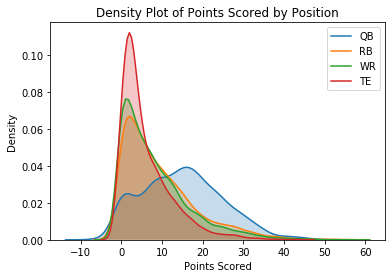

In [75]:
sns.kdeplot(raw_data.loc[raw_data['Pos'] == 'QB', 'DK_Total_FP'], label='QB', shade=True)
sns.kdeplot(raw_data.loc[raw_data['Pos'] == 'RB', 'DK_Total_FP'], label='RB', shade=True)
sns.kdeplot(raw_data.loc[raw_data['Pos'] == 'WR', 'DK_Total_FP'], label='WR', shade=True)
sns.kdeplot(raw_data.loc[raw_data['Pos'] == 'TE', 'DK_Total_FP'], label='TE', shade=True)
plt.xlabel('Points Scored'); plt.ylabel('Density'); plt.title('Density Plot of Points Scored by Position');

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


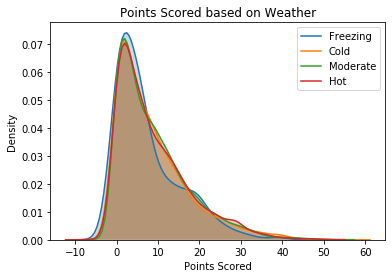

In [76]:
# Thought it might be interesting to look at player points scored distribution based on the weather (temperature)
outdoor_data = raw_data[raw_data['Indoor/Outdoor'] == 'outdoors']

# four buckets of temperature
temps = [0, 30, 50, 75, 100]
labels = ['Freezing', 'Cold', 'Moderate', 'Hot']

outdoor_data['Conditions'] = pd.cut(outdoor_data['Temperature'], temps, labels=labels)

sns.kdeplot(outdoor_data.loc[outdoor_data['Conditions'] == 'Freezing', 'DK_Total_FP'], label='Freezing', shade=True)
sns.kdeplot(outdoor_data.loc[outdoor_data['Conditions'] == 'Cold', 'DK_Total_FP'], label='Cold', shade=True)
sns.kdeplot(outdoor_data.loc[outdoor_data['Conditions'] == 'Moderate', 'DK_Total_FP'], label='Moderate', shade=True)
sns.kdeplot(outdoor_data.loc[outdoor_data['Conditions'] == 'Hot', 'DK_Total_FP'], label='Hot', shade=True)
plt.xlabel('Points Scored'); plt.ylabel('Density'); plt.title('Points Scored based on Weather');



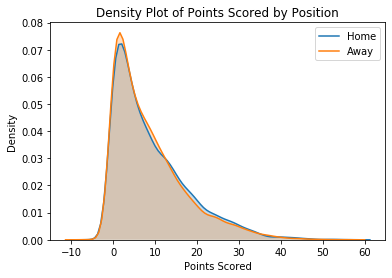

In [77]:
# and player performance for home vs away
sns.kdeplot(raw_data.loc[raw_data['H/A'] == 'H', 'DK_Total_FP'], label='Home', shade=True)
sns.kdeplot(raw_data.loc[raw_data['H/A'] == 'A', 'DK_Total_FP'], label='Away', shade=True)
plt.xlabel('Points Scored'); plt.ylabel('Density'); plt.title('Density Plot of Points Scored by Position');